## Get Started Object Detection

__Description__:

This notebook demonstrates how to perform object detection with DETR using HEART and MAITE

__Intended Audience__:

All T&E Users

## Contents:
1. Notebook imports and utility functions
2. Define the object detector
3. Prepare images for detection
4. Execute object detection
5. View detections
6. Execute simple evasion attack
7. Next Steps

## 1. Notebook imports

In [1]:

import torch
import numpy as np
from torchvision.transforms import transforms
from heart_library.estimators.object_detection import JaticPyTorchDETR
from heart_library.attacks.attack import JaticAttack

from art.attacks.evasion import ProjectedGradientDescent

import cv2
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

coco_labels = coco_labels = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

def extract_predictions(predictions_, conf_thresh):
    # Get the predicted class
    predictions_class = [coco_labels[i] for i in list(predictions_.labels)]
    #  print("\npredicted classes:", predictions_class)
    if len(predictions_class) < 1:
        return [], [], []
    # Get the predicted bounding boxes
    predictions_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(predictions_.boxes)]

    # Get the predicted prediction score
    predictions_score = list(predictions_.scores)
    # print("predicted score:", predictions_score)

    # Get a list of index with score greater than threshold
    threshold = conf_thresh
    predictions_t = [predictions_score.index(x) for x in predictions_score if x > threshold]
    if len(predictions_t) > 0:
        predictions_t = predictions_t  # [-1] #indices where score over threshold
    else:
        # no predictions esxceeding threshold
        return [], [], []
    # predictions in score order
    predictions_boxes = [predictions_boxes[i] for i in predictions_t]
    predictions_class = [predictions_class[i] for i in predictions_t]
    predictions_scores = [predictions_score[i] for i in predictions_t]
    return predictions_class, predictions_boxes, predictions_scores


def plot_image_with_boxes(img, boxes, pred_cls, title):
    img = (img*255).astype(np.uint8)
    text_size = 2
    text_th = 2
    rect_th = 2

    for i in range(len(boxes)):
        cv2.rectangle(img, (int(boxes[i][0][0]), int(boxes[i][0][1])), (int(boxes[i][1][0]), int(boxes[i][1][1])),
                      color=(0, 255, 0), thickness=rect_th)
        # Write the prediction class
        cv2.putText(img, pred_cls[i], (int(boxes[i][0][0]), int(boxes[i][0][1])), cv2.FONT_HERSHEY_SIMPLEX, text_size,
                    (0, 255, 0), thickness=text_th)

    plt.figure()
    plt.axis("off")
    plt.title(title)
    plt.imshow(img, interpolation="nearest")
    # plt.show()

## 2. Define the object detector

In [2]:
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225] 
preprocessing=(MEAN, STD)

detector = JaticPyTorchDETR(device_type='cpu',
                            input_shape=(3, 800, 800),
                            clip_values=(0, 1), 
                            attack_losses=( "loss_ce",
                                "loss_bbox",
                                "loss_giou",), 
                            preprocessing=(MEAN, STD))

Using cache found in /Users/kieranfraser/.cache/torch/hub/facebookresearch_detr_main
/Users/kieranfraser/git/work/cdao/gitlab/hardened-extension-adversarial-robustness-toolbox/env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/kieranfraser/git/work/cdao/gitlab/hardened-extension-adversarial-robustness-toolbox/env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## 3. Prepare images for detection

In [3]:
from datasets import load_dataset

data = load_dataset("guydada/quickstart-coco", split="train[20:25]")

preprocess = transforms.Compose([
    transforms.Resize(800),
    transforms.CenterCrop(800),
    transforms.ToTensor()
])

data = data.map(lambda x: {"image": preprocess(x["image"]), "label": None})

Resolving data files:   0%|          | 0/202 [00:00<?, ?it/s]

## 4. Execute Object Detection

In [4]:
detections = detector(data)

## 5. View detections

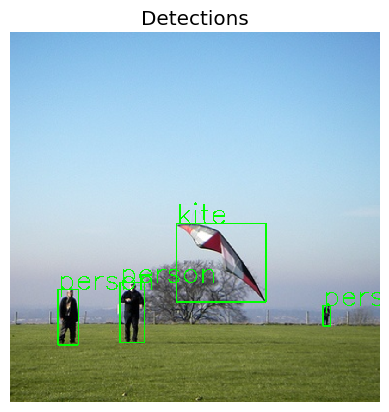

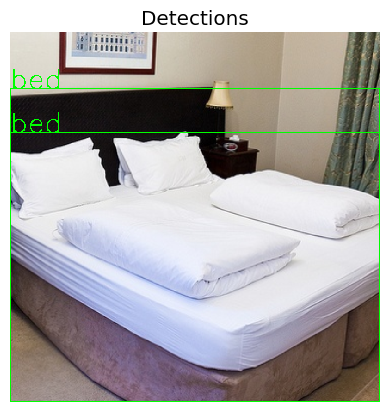

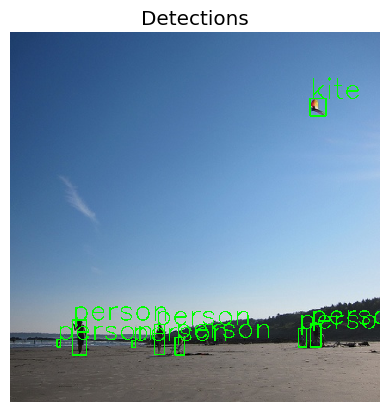

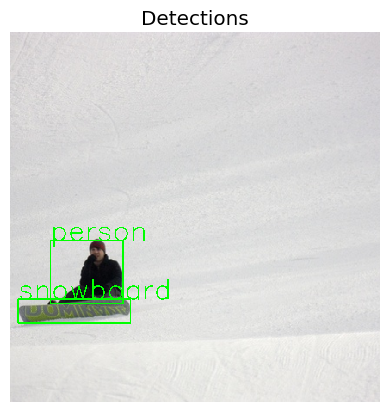

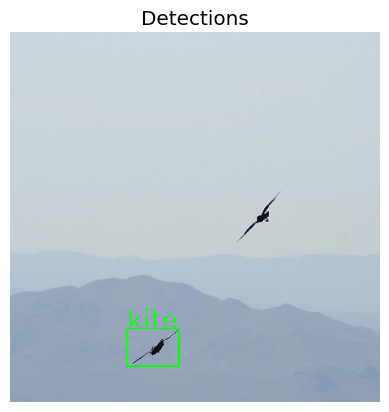

In [7]:
for i in range(len(data)):
    preds_orig = extract_predictions(detections[i], 0.8)
    img = np.asarray(data.__getitem__(i)['image']).transpose(1,2,0)
    plot_image_with_boxes(img=img.copy(), boxes=preds_orig[1], pred_cls=preds_orig[0], title="Detections")

## 6. Execute simple evasion attack

In [8]:
from typing import Tuple, Dict, Any, Sequence
from heart_library.estimators.object_detection.pytorch_detr import JaticPyTorchObjectDetectionOutput

class ImageDataset:
    def __init__(self, images, groundtruth, threshold=0.8):
        self.images = images
        self.groundtruth = groundtruth
        self.threshold = threshold
        
    def __len__(self)->int:
        return len(self.data)
    
    def __getitem__(self, ind: int) -> Tuple[np.ndarray, Sequence[JaticPyTorchObjectDetectionOutput], Dict[str, Any]]:
        image = self.images.__getitem__(ind)["image"]
        filtered_detection = self.groundtruth[ind]
        
        filtered_detection.boxes = filtered_detection.boxes[filtered_detection.scores>self.threshold]
        filtered_detection.labels = filtered_detection.labels[filtered_detection.scores>self.threshold]
        filtered_detection.scores = filtered_detection.scores[filtered_detection.scores>self.threshold]
        
        return (image, filtered_detection, None)

In [9]:
from copy import deepcopy

data_with_gt = ImageDataset(data, deepcopy(detections), threshold=0.5)
sample_data = torch.utils.data.Subset(data_with_gt, list(range(1)))

attack = JaticAttack(ProjectedGradientDescent(detector, max_iter=50, eps_step=0.01, eps=0.5, targeted=False))
adv_images, _, _ = attack(sample_data)

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

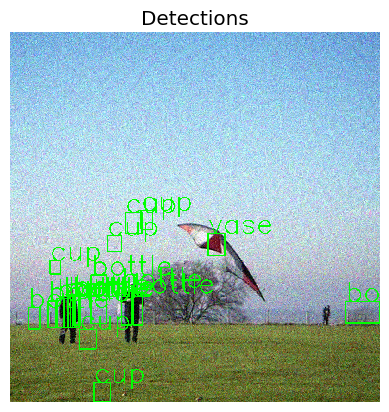

In [11]:
adv_detections = detector(adv_images)
for i in range(len(adv_detections)): 
    preds_orig = extract_predictions(adv_detections[i], 0.95)
    plot_image_with_boxes(img=adv_images[0][i].transpose(1,2,0).copy(),
                          boxes=preds_orig[1], pred_cls=preds_orig[0], title="Detections")

#### Targeted attack

```python
from typing import Tuple, Dict, Any
from copy import deepcopy

class TargetedImageDataset:
    def __init__(self, images, groundtruth, target_label):
        self.images = images
        self.groundtruth = groundtruth
        self.target_label = target_label
        
    def __len__(self)->int:
        return len(self.data)
    
    def __getitem__(self, ind: int) -> Tuple[np.ndarray, np.ndarray, Dict[str, Any]]:
        image = self.images.__getitem__(ind)["image"]
        targeted_detection = self.groundtruth[ind]
        targeted_detection.labels = [self.target_label]*len(targeted_detection.labels)
        return (image, targeted_detection, None)
    
targeted_data = TargetedImageDataset(data, deepcopy(detections), 12)

targeted_data = torch.utils.data.Subset(targeted_data, list(range(3)))

attack = JaticAttack(ProjectedGradientDescent(detector, max_iter=50, eps_step=0.003, eps=0.03, targeted=False))
output = attack.run_attack(data)
adv_images = np.asarray(output.images)
```

## 7. Next Steps
- Swap in your own dataset and detect objects
- Apply additional adversarial attacks to the object detector (e.g. adversarial patches)